In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pathlib
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from epymetheus import (
    Trade, 
    TradeHistory,
    TradeStrategy, 
    Universe,
    Backtester,
)

import seaborn
seaborn.set_style('ticks')

In [2]:
csvs = pathlib.Path('../data/JP Equity').glob('*.csv')
csvs = list(csvs)[:10]

df = pd.concat([
    pd.read_csv(csv, index_col=0, parse_dates=True) for csv in csvs
], axis=1)
df = df.loc[datetime.date(2000, 1, 1): datetime.date(2002, 12, 31), :]
df = df.dropna(axis=1, how='any')

universe = Universe(df, name='JP Equity')

universe.data

,8802,7267,2914,8031,6752,4452,9984,7203,6861,6501
Date,,,,,,,,,,
2000-01-01,1075.5,2092.8,815.3,802.7,3097.0,3222.8,5485.3,5565.2,13049.3,9613.4
2000-01-02,1075.5,2092.8,815.3,802.7,3097.0,3222.8,5485.3,5565.2,13049.3,9613.4
2000-01-03,1075.5,2092.8,815.3,802.7,3097.0,3222.8,5485.3,5565.2,13049.3,9613.4
2000-01-04,1094.9,2109.3,784.0,822.9,3179.1,3167.5,5776.9,5554.0,12137.4,9906.5
2000-01-05,1031.3,2076.3,785.0,864.5,3031.3,3062.5,4857.1,5497.8,11194.1,9232.4
...,...,...,...,...,...,...,...,...,...,...
2002-12-27,982.6,2482.6,855.4,645.0,1308.9,2961.8,232.6,3642.1,7227.5,2799.7
2002-12-28,982.6,2482.6,855.4,645.0,1308.9,2961.8,232.6,3642.1,7227.5,2799.7
2002-12-29,982.6,2482.6,855.4,645.0,1308.9,2961.8,232.6,3642.1,7227.5,2799.7


In [3]:
class SimpleMeanReversion(TradeStrategy):
    """
    A simple Mean Reversion strategy that buys stocks for a month with
    the lowest percentile one month returns and sells the highest percentile returns.

    Parameters
    ----------
    - percentile : float
        The threshold to buy or sell.
        E.g. If 0.1, buy/sell stocks with returns of lowest/highest 10%.
    """
    # XXX changed to trend follow

    def logic(self, universe, percentile):

        train_period = relativedelta(months=1)
        trade_period = relativedelta(months=1)

        def trade_bds(universe, train_period, trade_period):
            """Yield begin dates of trade periods."""
            d = universe.bars[0] + train_period
            while d + trade_period <= universe.bars[-1]:
                yield d
                d += trade_period

        def tot_return(asset, begin_date, end_date):
            """Return total return of asset from begin_date to end_date."""
            u = universe.data
            b, e = u.at[begin_date, asset], u.at[end_date, asset]
            return e / b - 1

        num_buysell = int(universe.n_assets * percentile)

        for trade_bd in trade_bds(universe, train_period, trade_period):
            train_bd = trade_bd - train_period
            trade_ed = trade_bd + trade_period - relativedelta(days=1)
            train_ed = train_bd + train_period - relativedelta(days=1)

            key = lambda asset: tot_return(asset, train_bd, train_ed)
            sell = sorted(universe.assets, key=key)[:num_buysell]
            buy = sorted(universe.assets, key=key)[-num_buysell:]
            
            for asset in sell:
                lot = 1.0 / universe.data.at[trade_bd, asset]
                yield Trade(asset=asset, lot=lot, open_date=trade_bd, close_date=trade_ed)
            
            for asset in buy:
                lot = -1.0 / universe.data.at[trade_bd, asset]
                yield Trade(asset=asset, lot=lot, open_date=trade_bd, close_date=trade_ed)

In [4]:
strategy = SimpleMeanReversion(percentile=0.1)

In [5]:
backtester = Backtester()

In [6]:
backtester.run(strategy, universe, verbose=True)

Evaluating wealth ...
Done.
Runtime : 0.1sec


In [7]:
wealth = backtester.wealth_

wealth

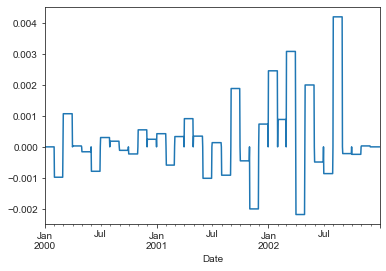

In [8]:
transaction = backtester.transaction_

transaction.to_frame().cumsum().sum(axis=1).plot()